## Underfit, Overfit e Regolarizzazione

Andiamo ora a discutere dell'elefante nella stanza di questo argomento: la soluzione calcolata tramite problema ai minimi quadrati non assomiglia neanche alla soluzione corretta. 

Per migliorare le prestazioni del nostro metodo, è necessario gestire in maniera corretta gli **iperparametri** del modello di approssimazione. 

> Gli **iperparametri** di un modello di approssimazione sono tutti i parametri del modello che devono essere selezionati a mano dall'utente, in contrapposizione con i parametri (ovvero, gli elementi del vettore $\alpha$), che vengono selezionati automaticamente come soluzione del problema ai minimi quadrati.

In particolare, il modello qui descritto aveva solamente **UN** iperparametro: il grado $d$ del polinomio che descrive il modello. Infatti, notiamo come il valore selezionato per gli esperimenti è $d = 5$, mentre i dati erano stati costruiti con il differente valore di $d = 3$.

Vediamo come cambia la soluzione mediante Equazioni Normali con Cholesky nel al crescere del grado $d$ del polinomio approssimante.

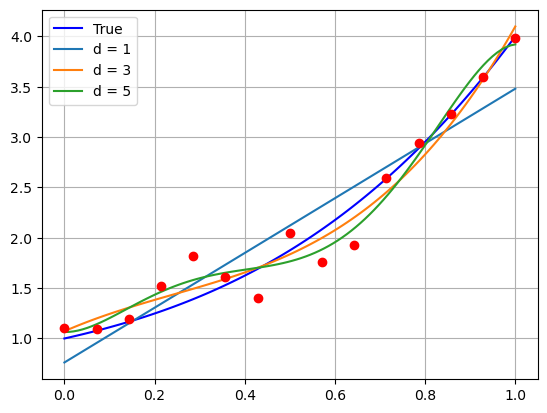

In [53]:
### Ri-definiamo i dati come fatto precedentemente 
# (imposto sigma = 0.2 invece che 0.1 per far risaltare meglio)
import numpy as np
import matplotlib.pyplot as plt

# Definiamo la funzione f(x, alpha) che prende in input il vettore alpha dei coefficienti e un valore x, e ritorna il valore del rispettivo polinomio
def f(x, alpha):
    d = alpha.shape[0] - 1 # abbiamo detto che la shape di alpha è (d+1, )

    y = np.zeros_like(x) # Questa è l'unica riga che dobbiamo cambiare rispetto a prima!
    for i in range(d+1):
        y = y + alpha[i] * x ** i
    return y

d_true = 3 # grado vero del polinomio
alpha_true = np.ones((d_true+1,))

# Numero di dati
n = 15

# Definiamo la deviazione standard del rumore
sigma = 0.2

# Generiamo il rumore
e = np.random.normal(loc=0, scale=sigma, size=(n, ))

# Definiamo gli x_i
x = np.linspace(0, 1, n)
y = f(x, alpha_true) + e

# Definiamo la matrice di Vandermonde
def vandermonde(x, d):
    r"""
    Preso in input un numpy array "x" di lunghezza (n, ) contentente i dati, e un valore intero "d" rappresentante il grado del polinomio, 
    costruisce e ritorna la matrice di vandermonde X di grado d, associata a x.

    Parameters:
    x (ndarray): Il vettore dei dati di input.
    d (int): Il grado massimo del polinomio.

    Returns:
    X (ndarray): La matrice di Vandermonde di grado "d", associata ad x.
    """
    n = x.shape[0]
    
    # Inizializzo la matrice di Vandermonde con shape (n, d+1)
    X = np.zeros((n, d+1))
    
    # Costruisco la matrice di Vandermonde
    for i in range(d+1):
        X[:, i] = x ** i
    return X

## Calcoliamo la soluzione con d variabile tra 0 e 4 e salviamole in una lista
alpha_chol = []
for d in range(6):
    # Matrice di Vandermonde di grado d
    X = vandermonde(x, d)

    # Troviamo la matrice L tale che X^T X = L L^T
    L = np.linalg.cholesky(X.T @ X)

    ###### Risolviamo il primo sistema:
    # Calcoliamo il termine noto X^T y
    Xty = X.T @ y

    # Troviamo z
    z = np.linalg.solve(L, Xty)

    ###### Risolviamo il secondo sistema:
    # Troviamo alpha
    alpha_chol.append(np.linalg.solve(L.T, z))

# Visualizziamo il plot
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
legend = ["True"]

plt.plot(xx, yy_true, 'b')
for d in range(1, 6, 2):
    yy_chol = f(xx, alpha_chol[d])
    plt.plot(xx, yy_chol)
    legend.append(f"d = {d}")
plt.plot(x, y, 'ro')
plt.legend(legend)
plt.grid()
plt.show()

## Underfit/Overfit
Tra le curve della figura sopra, osserviamo tre comportamenti distinti:

- Se $d=1$, la curva rappresenta una retta, e non è quindi sufficientemente flessibile da riuscire a recuperare il comportamento **complesso** della curva corretta. Il risultato sarà una scarsa approssimazione, incapace di recuperare l'andamento corretto dei dati. Questo fenomeno è spesso noto con il termine **underfit**.
- Se $d=5$, la curva diventa troppo flessibile, e inizia a seguire l'andamento oscillatorio del rumore. Questa curva, seppur in apparenza relativamente corretta, si comporterà non meglio di quella con $d=1$ in termini di abilità predittiva poiché, avendo imparato il comportamento del rumore, non è riuscita ad estrarre in maniera efficace il comportamento corretto della curva, e fallirà inevitabilmente se utilizzata per fare predizioni. Questo fenomento è noto con il nome di **overfit**.
- Se $d=3$, la curva ha un comportamento pressoché perfetto.

Diventa quindi chiaro come lo scopo finale nella costruzione di una curva di approssimazione sarà quello di identificare il valore corretto per l'iperparametro $d$, così da evitare in maniera efficace sia overfit che underfit.

Evitare situazioni di underfit è relativamente semplice andando a visualizzare il valore del residuo al variare del grado $d$ del polinomio approssimante:

In [54]:
def residuo(X, y, alpha):
    r = np.linalg.norm(X @ alpha - y) ** 2
    return r

for d in range(6):
    # Matrice di Vandermonde di grado d
    X = vandermonde(x, d)

    print(f"Residuo per d = {d}: {residuo(X, y, alpha_chol[d])}.")

Residuo per d = 0: 12.128425593166256.
Residuo per d = 1: 1.572961835336275.
Residuo per d = 2: 0.6076544904418518.
Residuo per d = 3: 0.49401934614780996.
Residuo per d = 4: 0.43835544914609725.
Residuo per d = 5: 0.361729909655626.


Osserviamo come il valore del residuo è molto grande quando $d$ è troppo piccolo, per poi scendere rapidamente quando ci si avvicina al valore esatto. 

```{note}
L'**underfit** rappresenta una curva di approssimazione poco flessibile. E' quindi estremamente semplice riconoscerlo andando a stampare il valore del residuo per ogni determinata scelta dell'iperparametro.
```

Non è altrettando semplice identificare l'overfit, poiché come si vede il residuo per $d=5$ è addirittura inferiore al residuo per $d=3$. Questo comportamento deriva dal fatto che il modello in overfit ha iniziato ad interpolare il rumore, e questo comporta una riduzione *fittizia* del residuo, che non correla però con una maggior abilità di far previsione.

Identificare l'overfit in maniera automatica è infatti uno dei grandi problemi aperti di questo campo al giorno d'oggi, poiché gli algoritmi ad oggi noti richiedono delle assunzioni che portano spesso ad una riduzione generale delle performance. 

Nella prossima sezione, vediamo un metodo semplice ma efficace per attenuare (e sperabilmente risolvere) il problema dell'overfit, una volta che lo si è individuato.

## Regolarizzazione
L'idea di questo approccio è la seguente: supponiamo che $d=3$ sia il grado **ottimale** per l'approssimazione, ma noi scegliamo (scorrettamente) $d=5$. Se gli ultimi due valori di $\alpha$ sono uguali a zero, allora il risultato ottenuto sarà come se avessimo scelto $d=3$.

Chiaramente, non possiamo sapere a priori esattamente quanti parametri dovranno essere uguali a zero. Ci limitiamo quindi a richiedere la nostro modello di porre *il maggior numero possibile* di valori uguale a zero, riducendo al minimo l'impatto sull'approssimazione.

Questo si riduce ad una formulazione del tipo seguente:

$$
\min_{\alpha} \frac{1}{2}|| X\alpha - y ||_2^2 + \frac{\lambda}{2} || \alpha ||_2^2,
$$

dove il primo termine è il classico problema ai minimi quadrati che abbiamo già visto precedentemente, mentre il secondo serve a richiedere che i valori di $\alpha$ siano il più piccoli possibile, andando quindi a forzare la presenza di vari elementi uguali a $0$, come detto. Questo termine è spesso chiamato **termine di regolarizzazione** e, se viene scelto nella forma appena descritto, prende il nome di **termine di regolarizzazione alla Tikhonov**.

Per risolvere questo problema di minimo, osserviamo che il suo gradiente è uguale a $0$ (e siamo quindi in presenza di un minimo), se:

$$
X^T X \alpha - X^T y + \lambda \alpha = 0,
$$

e quindi se

$$
(X^T X + \lambda I) \alpha = X^T y.
$$

Da notare che il sistema appena descritto rappresenta un'estensione naturale delle equazioni normali già utilizzate per i problemi dei minimi quadrati. Infatti, ponendo $\alpha = 0$, si ottengono esattamente le equazioni normali.

Notare che questo sistema può essere risolto anch'esso sia mediante Decomposizione di Cholesky (poiché $X^T X + \lambda I$ è **sempre** Simmetrica e Definita Positiva), sia tramite Decomposizione ai Valori Singolari. Vediamo come risolverla tramite metodo di Cholesky.

In [65]:
# Definiamo il valore per il parametro "lambda"
lmbda = 1 # NOTA: il nome "lambda" è riservato nel linguaggio di Python.
             #       usare una storpiatura del nome come "lmbda"

# Definiamo la matrice A := (X^T X + lambda * I)
A = X.T @ X + lmbda * np.eye(d+1)

# Calcoliamo la sua decomposizione di Cholesky
L = np.linalg.cholesky(A)

# Risolviamo i due sistemi triangolari
z = np.linalg.solve(L, X.T @ y)
alpha_chol = np.linalg.solve(L.T, z)

Vediamo come si comporta la curva di approssimazione con $d=5$ vista sopra, al variare del parametro $\lambda$.

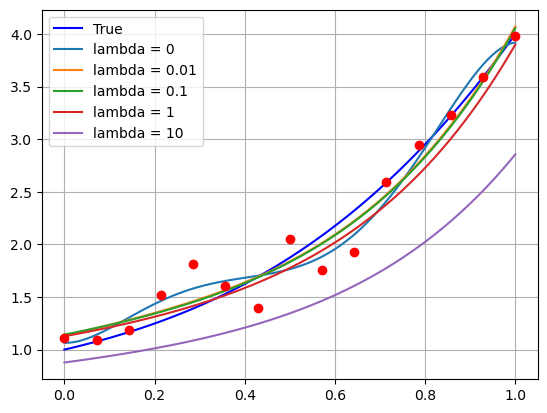

In [67]:
## Calcoliamo le soluzioni con lambda variabile e salviamole in una lista
lmbda_list = [0, 1e-2, 1e-1, 1, 10]

# Matrice di Vandermonde di grado d
d = 5
X = vandermonde(x, d)

alpha_chol = []
for lmbda in lmbda_list:
    # Troviamo la matrice L tale che X^T X = L L^T
    L = np.linalg.cholesky(X.T @ X + lmbda * np.eye(d+1))

    ###### Risolviamo il primo sistema:
    # Calcoliamo il termine noto X^T y
    Xty = X.T @ y

    # Troviamo z
    z = np.linalg.solve(L, Xty)

    ###### Risolviamo il secondo sistema:
    # Troviamo alpha
    alpha_chol.append(np.linalg.solve(L.T, z))

# Visualizziamo il plot
xx = np.linspace(0, 1, 100)
yy_true = f(xx, alpha_true)
legend = ["True"]

plt.plot(xx, yy_true, 'b')
for i, lmbda in enumerate(lmbda_list):
    yy_chol = f(xx, alpha_chol[i])
    plt.plot(xx, yy_chol)
    legend.append(f"lambda = {lmbda}")
plt.plot(x, y, 'ro')
plt.legend(legend)
plt.grid()
plt.show()

E' dunque abbastanza palese come, per valori relativamente piccoli di $\lambda$, la soluzione ottenuta è molto migliore di quella che avevamo visto nel caso precedente in cui non era presente il termine di regolarizzazione, e come questo metodo permette di ottenere un buon modello approssimante anche senza stimare in maniera precisa il grado *corretto* del polinomio.

Chiaramente, nel caso in cui $\lambda$ sia scelto troppo grande, il termine di Regolarizzazione inizia a dominare in maniera esagerata la soluzione, generando una curva che manifesta dei parametri **troppo piccoli**, e che quindi non è in grado di fittare correttamente i dati considerati, portando a **underfit**.

Nonostante ciò, scegliere un parametro $\lambda$ adeguato è in pratica **estremamente** più semplice di trovare il grado corretto, sia perché sono presenti in letteratura vari metodi per selezionarlo automaticamente, sia perché come si vede dall'esempio sopra il range di valori di $\lambda$ per cui la ricostruzione è buona è particolarmente grande.

## Il metodo LASSO
Più recentemente, sono emersi in letteratura centinaia di algoritmi che migliorano le prestazioni del metodo appena proposto. La principale linea di ricerca si concentra sul determinare differenti **funzioni di regolarizzazione** alternative al termine di Tihkonov.

Tra queste, il metodo senza dubbio più utilizzato in pratica è quello detto LASSO, una cui formulazione è la seguente:

$$
\min_{\alpha} || X \alpha - y ||_2^2 + \lambda || \alpha ||_1.
$$

L'idea dietro a LASSO è la seguente: andando a visualizzare la **forma** delle curve di livello della norma 1 rispetto alla norma 2, si nota subito come il punto di intersezione di una retta casuale tangente a tali curve ha una probabilità molto più alta di stare su uno degli assi del piano cartesiano. Questo comporta come conseguenza che la norma 1 favorisce delle soluzioni $\alpha$ contenente un numero maggiore di elementi uguali a zero, che è esattamente quello che vorremmo ottenere con la regolarizzazione, per quanto descritto nei capitoli precedenti.

![](/imgs/1norm_2norm.jpg)

Sebbene tale metodo sia noto per la sua efficacia, la sua applicabilità è ridotta dal fatto che la risoluzione di questo problema non è associata a nessun tipo di equazioni normali (per via della norma 1), e quindi richiede di sviluppare algoritmi più avanzati per risolvere tale problema di minimo.

Nella prossima sezione, ci dedicheremo quindi a discutere di algoritmi più generali per risolvere problemi come quello sopra proposto, che tornerà più volte anche nella parte del corso dedicata all'Imaging.